In [1]:
from IPython.display import clear_output, Audio
%pip install torchmetrics
%pip install pytorch-ignite
%pip install librosa
%pip install pydub
clear_output()

In [2]:
import os
import random
import math
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

import torch
import torchaudio
from torchaudio.utils import download_asset
import torchaudio.functional as F
import torchaudio.transforms as T
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as tf
import torch.nn.functional as f
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as sc

import re
from pydub import AudioSegment
import librosa

REPRODUCIBILITY AND GPU ACCESS

In [3]:
# https://gist.github.com/ihoromi4/b681a9088f348942b01711f251e5f964
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(42)

In [4]:
#Checking GPU access
print(f"We have {'' if torch.cuda.is_available() else 'not'}access to a GPU")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print(torch.cuda.current_device())
    print(torch.cuda.device(0))
    print(torch.cuda.device_count())
    print(torch.cuda.get_device_name(0))
    print(device)

We have access to a GPU
0
1
Tesla T4
cuda


MOUNTING DRIVE

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


DATA VISUALIZATION AND PREPROCESSING


In [6]:
#Increasing the sizes of all figures of the plt function in the notebook
plt.rcParams["figure.figsize"] = (12,15)

In [7]:
#Normalization function between -1 and 1
def normalize(signal):
  return 2*(signal-torch.min(signal))/(torch.max(signal)-torch.min(signal))-1

torch.Size([50085]) torch.Size([50085])


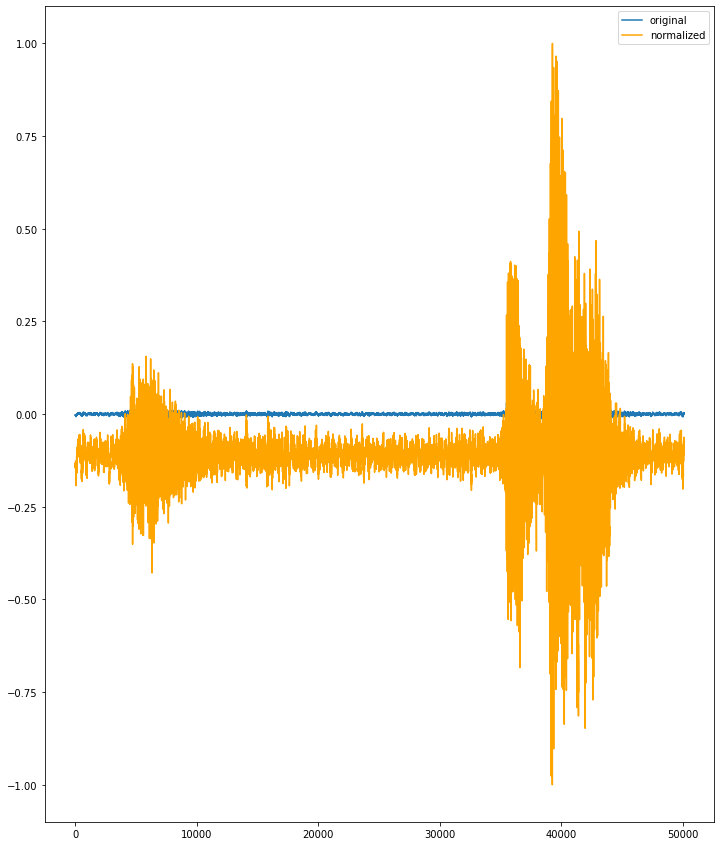

In [8]:
#Visualizing one audio waveform before and after normalization and reproducing it
s, sr = torchaudio.load('/content/drive/MyDrive/ses1/wavRE/Ses01F_impro01_F002,neu.wav')
s = s.mean(axis=0)  # multiple channels, average
print(s.shape, normalize(s).shape)

#plotting the waveforms
fig, ax = plt.subplots()
ax.plot(s.squeeze(), label = 'original')
ax.plot(normalize(s).squeeze(), label = 'normalized', color = 'orange')
ax.legend()

Audio(s, rate = sr)

TRIM AUDIO


In [9]:
#trim audios in order to get 1 emotion for 1 audio

filepath = '/content/drive/My Drive/ses1/wavRE/'
dir = os.listdir(filepath)
if len(dir) != 0:     #trim the audio only if the directory is empy
    print("Not empty directory, not doing trimming")
else:
    print("empty directory , doing trimming")

    info_line = re.compile(r'\[.+\]\n', re.IGNORECASE)

    for sess in [1]:
      emo_evaluation_dir = '/content/drive/My Drive/ses1/EmoEvaluation/'.format(sess)
      evaluation_files = [l for l in os.listdir(emo_evaluation_dir) if 'Ses' in l]
      for file in evaluation_files:
          with open(emo_evaluation_dir + file) as f:
              content = f.read()
          info_lines = re.findall(info_line, content)
          for line in info_lines[1:]:  # the first line is a header
              start_end_time, wav_file_name, emotion, val_act_dom = line.strip().split('\t')
              start_time, end_time = start_end_time[1:-1].split('-')
              start_time, end_time = float(start_time), float(end_time)
              wav_dir = '/content/drive/My Drive/ses1/wav/'.format(sess)
              wav_files = [l for l in os.listdir(emo_evaluation_dir) if 'Ses' in l]
              ev_f_name= file[:-4]
            
              for f in wav_files:
                w_f_name= f[:-4]
              
                if(w_f_name==ev_f_name): #if the audio file corresponds in the evaluation directory 
                
                  wav = AudioSegment.from_wav('/content/drive/My Drive/ses1/wav/'+f[:-4]+'.wav')
                  wav_corretto=wav[start_time*1000:end_time*1000] #start_time and end_time were in ms
                  path_in= '/content/drive/My Drive/ses1/wav/'+f[:-4]+'.wav'
                  path_out='/content/drive/My Drive/ses1/wavRE/'+wav_file_name+','+emotion+'.wav'
                  wav_corretto.export(path_out, format="wav")

Not empty directory, not doing trimming


DATAFRAME


In [10]:
_ext_audio = '.wav'
_emotions = {'ang': 0,
                'hap': 1,
                'exc': 2,
                'sad': 3,
                'fru': 4,
                'fea': 5,
                'sur': 6,
                'neu': 7,
                'xxx': 8,
                'oth': 9,
                'dis': 10}
root = '/content/drive/MyDrive/ses1/wavRE'
data = []
cut=3  
for _, _, files in os.walk(root):
  for file in files:
    if file.endswith(_ext_audio):
      s,sr= torchaudio.load(os.path.join(root,file), num_frames = cut*sr)
      s = s.mean(axis=0)  # multiple channels, average
      samples = s.size(-1) #length in frames or samples
      seconds = samples/sr #length signal in seconds
      if seconds < cut: 
        s = f.pad(s,(0, cut*sr-samples))  #pad until reaches desired dim
      # Construct file identifiers
      roba=file[:-4].strip().split(',')
      identifiers = [roba[0],roba[1], s, os.path.join(file)]
      # Append identifier to data
      data.append(identifiers)
      # Create pandas dataframe
      df = pd.DataFrame(data, columns=['info', 'emotion', 'signal', 'file'])
      # Map emotion labels to numeric values
      df['emotion'] = df['emotion'].map(_emotions)

print(df)


                        info  emotion  \
0        Ses01F_impro03_F000        1   
1        Ses01F_impro03_F001        1   
2        Ses01F_impro03_F002        1   
3        Ses01F_impro03_F003        8   
4        Ses01F_impro03_F004        1   
...                      ...      ...   
1814  Ses01F_script03_1_M034        1   
1815  Ses01F_script03_1_M035        8   
1816  Ses01F_script03_1_M036        1   
1817  Ses01F_script03_1_M037        1   
1818  Ses01F_script03_1_M038        8   

                                                 signal  \
0     [tensor(-0.0023), tensor(-0.0012), tensor(-0.0...   
1     [tensor(-0.0041), tensor(-0.0041), tensor(-0.0...   
2     [tensor(0.1703), tensor(0.1227), tensor(0.0803...   
3     [tensor(0.0135), tensor(0.0003), tensor(0.0002...   
4     [tensor(0.0163), tensor(0.0163), tensor(0.0149...   
...                                                 ...   
1814  [tensor(-0.0036), tensor(-0.0044), tensor(-0.0...   
1815  [tensor(-0.0003), tensor(-6.1

In [11]:
#Counting how the label classes are distributed in the dataset, in order to counter data imbalance later
freq = df['emotion'].value_counts()
print(freq)
class_weights = torch.tensor([freq[0]/len(df),freq[1]/len(df),freq[2]/len(df),freq[3]/len(df),freq[4]/len(df),freq[5]/len(df),freq[6]/len(df),freq[7]/len(df),freq[8]/len(df),freq[9]/len(df),freq[10]/len(df)], device = device)
print(class_weights)

8     415
7     384
4     280
0     229
3     194
2     143
1     135
6      25
5      12
9       1
10      1
Name: emotion, dtype: int64
tensor([0.1259, 0.0742, 0.0786, 0.1067, 0.1539, 0.0066, 0.0137, 0.2111, 0.2281,
        0.0005, 0.0005], device='cuda:0', dtype=torch.float64)


MEL-FREQUENCY CEPSTRAL COEFFICIENTS (MFCCs)

In [12]:
#Parameters for the mel-spectrogram and MFCCs computation
n_fft = 1024
win_length = int(sr*64/1000)    #64 ms 
hop_length = int(sr*16/1000)    #16 ms
n_mels = 128
n_mfcc = 40

#defining the function to retrieve the MFC coefficients
mfcc_transform = T.MFCC(sample_rate = sr, n_mfcc = n_mfcc, log_mels = True, melkwargs={"n_fft": n_fft,
                                                                             "n_mels": n_mels,
                                                                             "hop_length": hop_length,
                                                                             "mel_scale": "htk",
                                                                             'f_min': 40, #HZ
                                                                             'f_max': 7600})

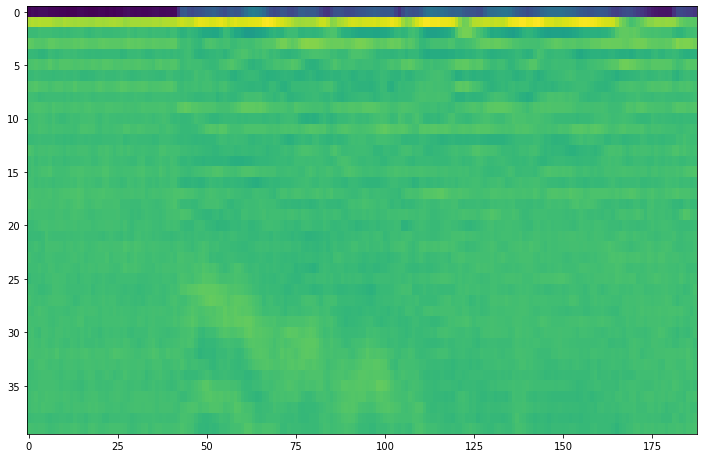

In [13]:
#Applying the transform on a random example
mfcc = mfcc_transform(s)

#Plotting the MFCCs as image, as they are input to the 
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(mfcc.squeeze())
ax.set_aspect(3)
plt.show()

DATASET 

In [14]:
#DATASET
#Standard pytorch definition of the Dataset class, customized to read the DataFrame and return the inputs and labels for the model
class IemoDataset(Dataset): 
    def __init__(self, df = None, transform=None):
      self.df = df
      self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        waveform = self.df.loc[idx,'signal'] #locating the signal 
        mfcc = mfcc_transform(waveform).to(device) #transforming it and sending it to the GPU
        emotion = self.df.loc[idx,'emotion'] #locating the label/class/emotion
        emotion = torch.tensor(emotion, dtype = int, device = device) #creating a tensor in the GPU

        #Applying transformation, if necessary
        if self.transform:
            sample=self.transform(mfcc)
        
        return mfcc.unsqueeze(dim=0), emotion

torch.Size([1, 40, 188]) tensor(4, device='cuda:0')
The emotion of this audio is the 4


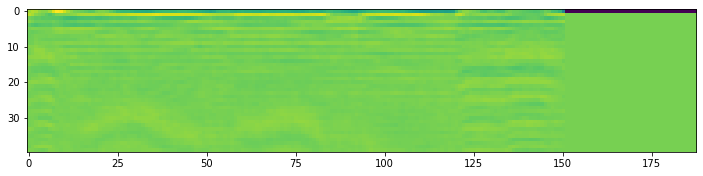

In [15]:
#Initializing the dataset
iemodb = IemoDataset(df)
#Printing a random example to see if everything is correct
example , emotion = random.choice(iemodb)
print(example.shape, emotion) #printing the size of the tensors returned by the dataset

#plotting the MFCCs
plt.imshow(example.squeeze().cpu())

print(f"The emotion of this audio is the {emotion}")

REINITIALIZING DATASET AFTER THE TRASFORMATION AND TRAIN/VAL SPLIT

In [16]:
#TRAIN TEST SPLIT
train_size = int(0.8 * len(iemodb))
test_size = len(iemodb) - train_size

#Splitting the dataset in validation (20%) and train (80%)
train_dataset, test_dataset = torch.utils.data.random_split(iemodb, [train_size, test_size])

print(f"Lenght of the training dataset is {len(train_dataset)} items")
print(f"Lenght of the validation dataset is {len(test_dataset)} items")
# Shapes of the dataset
print(f"The shape of the first mfcc image in the test dataset is {train_dataset[0][0].shape}")
print(f"The shape of the label emotion of the first audio in the train dataset is {train_dataset[0][1].shape}")
print(f"The shape of the first mfcc image in the validation dataset is {test_dataset[0][0].shape}")
print(f"The shape of the label emotion of the first audio in the validation dataset is {test_dataset[0][1].shape}")


Lenght of the training dataset is 1455 items
Lenght of the validation dataset is 364 items
The shape of the first mfcc image in the test dataset is torch.Size([1, 40, 188])
The shape of the label emotion of the first audio in the train dataset is torch.Size([])
The shape of the first mfcc image in the validation dataset is torch.Size([1, 40, 188])
The shape of the label emotion of the first audio in the validation dataset is torch.Size([])


MODEL

In [17]:
#Function that calculates the correct padding for all the convolutions in the model
def calc_padding(k1,k2,h,w):
  o1 = h
  o2 = w
  s=1
  p1 = (s*(o1-1) + k1-h)//2
  p2 = (s*(o2-1) + k2-w)//2
  return p1, p2

In [18]:
#Calculate the correct padding for all convolutions
h = example.size(1)
w = example.size(2)
print(f"Padding needed for the convolutions in the Parallel Paths are {calc_padding(11,1,h,w),calc_padding(1,9,h,w),calc_padding(3,3,h,w)}")
print(f"Padding needed for the convolution in the Feature Learning is {calc_padding(1,1,h,w)}")

Padding needed for the convolutions in the Parallel Paths are ((5, 0), (0, 4), (1, 1))
Padding needed for the convolution in the Feature Learning is (0, 0)


In [19]:
class ParallelPaths(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv_pp1 = nn.Conv2d(padding = calc_padding(11,1,h,w), stride= 1, in_channels=1, out_channels=32,padding_mode= 'replicate', kernel_size=(11,1))
        self.conv_pp2 = nn.Conv2d(padding = calc_padding(1,9,h,w), stride= 1, in_channels=1, out_channels=32,padding_mode= 'replicate', kernel_size=(1,9))
        self.conv_pp3 = nn.Conv2d(padding = calc_padding(3,3,h,w), stride= 1, in_channels=1, out_channels=32,padding_mode= 'replicate', kernel_size=(3,3))
        self.batch_norm_pp = nn.BatchNorm2d(32)
        self.relu_pp = nn.PReLU()
        self.avg = nn.AvgPool2d( kernel_size = 1, stride =1 ) #in the paper kernel_size is 2

    def forward(self, x):
        start=x
        #first path
        x1 = self.conv_pp1(start)
        x1 = self.batch_norm_pp(x1)
        x1 = self.relu_pp(x1)
        x1 = self.avg(x1)
        x1 = x1 + start #added for better gradient propagation
        #second path
        x2 = self.conv_pp2(start)
        x2 = self.batch_norm_pp(x2)
        x2 = self.relu_pp(x2)
        x2 = self.avg(x2)
        x2 = x2 + start
        #third path
        x3 = self.conv_pp3(start)
        x3 = self.batch_norm_pp(x3)
        x3 = self.relu_pp(x3)
        x3 = self.avg(x3)
        x3 = x3 + start
        #concatenate tensor along last dimension
        x = torch.cat((x1,x2,x3),-1) 
        return x

class FeatureExtractor(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv_fe1 = nn.Conv2d(padding = calc_padding(3,3,h,w),in_channels=32, out_channels=64,padding_mode= 'replicate', kernel_size=(3,3), stride=(1,1), bias = False)
        self.conv_fe2 = nn.Conv2d(padding = calc_padding(3,3,h,w),in_channels=64, out_channels=96,padding_mode= 'replicate', kernel_size=(3,3), stride=(1,1), bias = False)
        self.conv_fe3 = nn.Conv2d(padding = calc_padding(3,3,h,w),in_channels=96, out_channels=128, padding_mode= 'replicate',kernel_size=(3,3), stride=(1,1), bias = False)
        self.conv_fe4 = nn.Conv2d(padding = calc_padding(3,3,h,w),in_channels=128, out_channels=160,padding_mode= 'replicate', kernel_size=(3,3), stride=(1,1), bias = False)
        self.conv_fe5 = nn.Conv2d(padding = calc_padding(1,1,h,w),in_channels=160, out_channels=320,padding_mode= 'replicate', kernel_size=(1,1), stride=(1,1), bias = False)
        self.relu_fe = nn.PReLU()
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(96)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(160)
        self.bn5 = nn.BatchNorm2d(320)
        self.avg2 = nn.AvgPool2d(padding=0 , kernel_size =(1,1), stride =1)
        self.avg1 = nn.AvgPool2d(padding=0 , kernel_size =(2,2), stride =1)

    def forward(self, x):
      
      
      x = self.conv_fe1(x)
      x = self.bn1(x)
      x = self.relu_fe(x)
      x = self.avg2(x)

      
      x = self.conv_fe2(x)
      x = self.bn2(x)
      x = self.relu_fe(x)
      x = self.avg2(x)

      
      x = self.conv_fe3(x)
      x = self.bn3(x)
      x = self.relu_fe(x)
      x = self.avg2(x)
    
      x = self.conv_fe4(x)
      x = self.bn4(x)
      x = self.relu_fe(x)
      x = self.avg2(x)

    
      x = self.conv_fe5(x)
      x = self.bn5(x)
      x = self.relu_fe(x)
      x = x.mean([2,3]) #global average pooling
      
      return x

class CNN(nn.Module):
    """
    Implementation of the CNN as described in the paper.
    """
    def __init__(self):
        super().__init__()

        self.pp = ParallelPaths()
        self.fe = FeatureExtractor()
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(in_features = 320, out_features = 11)


    def forward(self, x):
      x = self.pp(x)
      x = self.fe(x)
      x = self.dropout(x)
      x = self.fc(x)
      #x = self.softmax(x) #because in the pytorch cross entropy the softmax is already done 

      return x

In [20]:
from torchsummary import summary
#Initialize the Concolutional Neural Network
cnn_net = CNN()
cnn_net = cnn_net.to(device)
#Visualize it by sending a random input which as the same shape of the data
summary(cnn_net,(1,h,w))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 32, 40, 188]             384
       BatchNorm2d-2          [-1, 32, 40, 188]              64
             PReLU-3          [-1, 32, 40, 188]               1
         AvgPool2d-4          [-1, 32, 40, 188]               0
            Conv2d-5          [-1, 32, 40, 188]             320
       BatchNorm2d-6          [-1, 32, 40, 188]              64
             PReLU-7          [-1, 32, 40, 188]               1
         AvgPool2d-8          [-1, 32, 40, 188]               0
            Conv2d-9          [-1, 32, 40, 188]             320
      BatchNorm2d-10          [-1, 32, 40, 188]              64
            PReLU-11          [-1, 32, 40, 188]               1
        AvgPool2d-12          [-1, 32, 40, 188]               0
    ParallelPaths-13          [-1, 32, 40, 564]               0
           Conv2d-14          [-1, 64, 

DATALOADER


The valued stored in the tensor of the label of the first signal is 1
The size of the batch of images is torch.Size([32, 1, 40, 188])
The size of the batch of labels is torch.Size([32])


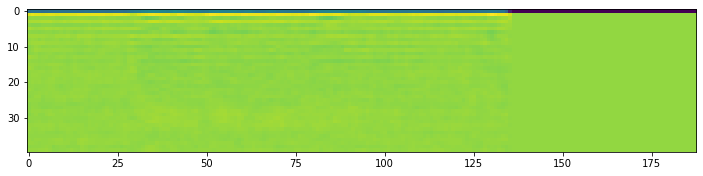

In [21]:
#DATALOADER
#Initializing the Dataloader and setting the size of each batch
BATCH_SIZE = 32
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
validation_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, drop_last=True)

#Checking that everything is fine in the Dataloader
mfcc, train_labels = next(iter(train_dataloader)) #iterate in the Dataloader
#Visualize the first input image mfcc 
plt.imshow(mfcc[0].squeeze().cpu())
#Print fisrt label emotion
print(f"The valued stored in the tensor of the label of the first signal is {train_labels[0]}")
#Print shapes of data inside Dataloader
print(f"The size of the batch of images is {mfcc.size()}")
print(f"The size of the batch of labels is {train_labels.size()}")

LOSS

In [22]:
###FOCAL LOSS
# https://github.com/VSainteuf/pytorch-psetae/blob/master/learning/focal_loss.py
from torch.autograd import Variable

class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = f.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

METRICS AND IGNITE

In [23]:
#TRAINING with ignite library
from ignite.metrics import Precision, Recall, Loss
from ignite.engine import create_supervised_evaluator

LR =  1e-4 #learning rate prima era 5e-5

#METRICS
#In the paper they use 3 metrics UA, WA, F1
metric0 = Precision(average=True)     #UA
metric1 = Precision(average='weighted') #WA
precision = Precision(average=False)
recall = Recall(average=False)
F1 = ((precision * recall * 2 / (precision + recall)).mean())*100 #F1

#LOSS CRITERIONS 
#In the paper they try 2 criterions CE and F-Loss
criterion = torch.nn.CrossEntropyLoss()
criterion2 = FocalLoss(gamma=2, alpha = class_weights)

#OPTIMIZER
optimizer = optim.Adam(cnn_net.parameters(), lr = LR, weight_decay=1e-6)

#SCHEDULER
scheduler = sc.ExponentialLR(optimizer, gamma = 0.86) 

# Accuracy and loss metrics are defined
val_metrics = {
  "accuracy": metric0*100,
  "weighted acc": metric1*100,
  "ce_loss": Loss(criterion),
  "focal_loss": Loss(criterion2) }


train_evaluator = create_supervised_evaluator(cnn_net, metrics=val_metrics, device=device)
val_evaluator = create_supervised_evaluator(cnn_net, metrics=val_metrics, device=device)

TRAINING


In [24]:
#Training/Validation functions, events and handlers are adapted from the IGNITE library documentation
from ignite.engine import Engine,create_supervised_evaluator

def train_step(engine, batch):
    x, y = batch

    cnn_net.train()
    y_pred = cnn_net(x)
    loss = criterion2(y_pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss

# Define a trainer engine
trainer = Engine(train_step)

def validation_step(engine, batch):
    cnn_net.eval()
    with torch.no_grad():
        x, y = batch[0], batch[1]
        y_pred = cnn_net(x)

        return y_pred, y

train_evaluator = Engine(validation_step)
val_evaluator = Engine(validation_step)

# Attach metrics to the evaluators
for name, metric in val_metrics.items():
    metric.attach(train_evaluator, name)

for name, metric in val_metrics.items():
    metric.attach(val_evaluator, name)

#attach F1 to evaluators
F1.attach(train_evaluator, "F1_score")
F1.attach(val_evaluator, "F1_score")

In [25]:
from ignite.engine import Events
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_dataloader)
    metrics = train_evaluator.state.metrics
    print(f"Training Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f}% Avg F1: {metrics['F1_score']:.2f}% Avg weig accuracy: {metrics['weighted acc']:.2f}%  Avg Focal loss: {metrics['focal_loss']:.2f}  Avg CE loss: {metrics['ce_loss']:.2f}")


@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    val_evaluator.run(validation_loader)
    metrics = val_evaluator.state.metrics
    print(f"Validation Results - Epoch[{trainer.state.epoch}] Avg accuracy: {metrics['accuracy']:.2f}% Avg F1: {metrics['F1_score']:.2f}% Avg weig accuracy: {metrics['weighted acc']:.2f}%  Avg Focal loss: {metrics['focal_loss']:.2f}  Avg CE loss: {metrics['ce_loss']:.2f}")


In [26]:
from ignite.contrib.handlers import ProgressBar

ProgressBar().attach(trainer, output_transform=lambda x: {'batch loss': x})

In [27]:
from ignite.handlers import ModelCheckpoint, global_step_from_engine

# Score function to select relevant metric, here f1
def score_function(engine):
    return engine.state.metrics["weighted acc"]

# Checkpoint to store n_saved best models wrt score function
model_checkpoint = ModelCheckpoint(
    "SER",
    n_saved=1,
    filename_prefix="best",
    score_function=score_function,
    score_name="weighted acc",
    global_step_transform=global_step_from_engine(trainer),
)
  
# Save the model (if relevant) every epoch completed of evaluator
train_evaluator.add_event_handler(Events.COMPLETED, model_checkpoint, {"model": cnn_net});

In [28]:
trainer.run(train_dataloader, max_epochs=100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[1] Avg accuracy: 8.86% Avg F1: nan% Avg weig accuracy: 17.39%  Avg Focal loss: 0.24  Avg CE loss: 2.11
Validation Results - Epoch[1] Avg accuracy: 7.46% Avg F1: nan% Avg weig accuracy: 16.98%  Avg Focal loss: 0.24  Avg CE loss: 2.06


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[2] Avg accuracy: 8.79% Avg F1: nan% Avg weig accuracy: 17.29%  Avg Focal loss: 0.20  Avg CE loss: 1.96
Validation Results - Epoch[2] Avg accuracy: 8.03% Avg F1: nan% Avg weig accuracy: 18.10%  Avg Focal loss: 0.20  Avg CE loss: 1.90


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[3] Avg accuracy: 9.10% Avg F1: nan% Avg weig accuracy: 17.93%  Avg Focal loss: 0.19  Avg CE loss: 1.90
Validation Results - Epoch[3] Avg accuracy: 8.30% Avg F1: nan% Avg weig accuracy: 18.88%  Avg Focal loss: 0.18  Avg CE loss: 1.83


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[4] Avg accuracy: 8.67% Avg F1: nan% Avg weig accuracy: 17.15%  Avg Focal loss: 0.18  Avg CE loss: 1.86
Validation Results - Epoch[4] Avg accuracy: 8.18% Avg F1: nan% Avg weig accuracy: 18.10%  Avg Focal loss: 0.17  Avg CE loss: 1.79


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[5] Avg accuracy: 14.01% Avg F1: nan% Avg weig accuracy: 24.00%  Avg Focal loss: 0.17  Avg CE loss: 1.84
Validation Results - Epoch[5] Avg accuracy: 12.53% Avg F1: nan% Avg weig accuracy: 21.99%  Avg Focal loss: 0.17  Avg CE loss: 1.77


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[6] Avg accuracy: 14.88% Avg F1: nan% Avg weig accuracy: 25.01%  Avg Focal loss: 0.17  Avg CE loss: 1.83
Validation Results - Epoch[6] Avg accuracy: 12.47% Avg F1: nan% Avg weig accuracy: 21.62%  Avg Focal loss: 0.16  Avg CE loss: 1.74


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[7] Avg accuracy: 13.44% Avg F1: nan% Avg weig accuracy: 23.06%  Avg Focal loss: 0.16  Avg CE loss: 1.81
Validation Results - Epoch[7] Avg accuracy: 12.02% Avg F1: nan% Avg weig accuracy: 21.67%  Avg Focal loss: 0.16  Avg CE loss: 1.74


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[8] Avg accuracy: 18.09% Avg F1: nan% Avg weig accuracy: 28.88%  Avg Focal loss: 0.16  Avg CE loss: 1.81
Validation Results - Epoch[8] Avg accuracy: 12.16% Avg F1: nan% Avg weig accuracy: 21.38%  Avg Focal loss: 0.16  Avg CE loss: 1.73


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[9] Avg accuracy: 13.62% Avg F1: nan% Avg weig accuracy: 23.24%  Avg Focal loss: 0.16  Avg CE loss: 1.78
Validation Results - Epoch[9] Avg accuracy: 14.33% Avg F1: nan% Avg weig accuracy: 24.05%  Avg Focal loss: 0.16  Avg CE loss: 1.71


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[10] Avg accuracy: 12.94% Avg F1: nan% Avg weig accuracy: 22.36%  Avg Focal loss: 0.16  Avg CE loss: 1.80
Validation Results - Epoch[10] Avg accuracy: 12.95% Avg F1: nan% Avg weig accuracy: 23.57%  Avg Focal loss: 0.16  Avg CE loss: 1.75


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[11] Avg accuracy: 15.39% Avg F1: nan% Avg weig accuracy: 25.68%  Avg Focal loss: 0.16  Avg CE loss: 1.78
Validation Results - Epoch[11] Avg accuracy: 13.66% Avg F1: nan% Avg weig accuracy: 23.52%  Avg Focal loss: 0.15  Avg CE loss: 1.71


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[12] Avg accuracy: 16.70% Avg F1: nan% Avg weig accuracy: 26.57%  Avg Focal loss: 0.16  Avg CE loss: 1.77
Validation Results - Epoch[12] Avg accuracy: 23.46% Avg F1: nan% Avg weig accuracy: 41.00%  Avg Focal loss: 0.16  Avg CE loss: 1.71


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[13] Avg accuracy: 15.85% Avg F1: nan% Avg weig accuracy: 26.18%  Avg Focal loss: 0.16  Avg CE loss: 1.77
Validation Results - Epoch[13] Avg accuracy: 13.83% Avg F1: nan% Avg weig accuracy: 24.16%  Avg Focal loss: 0.15  Avg CE loss: 1.70


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[14] Avg accuracy: 18.58% Avg F1: nan% Avg weig accuracy: 30.00%  Avg Focal loss: 0.16  Avg CE loss: 1.77
Validation Results - Epoch[14] Avg accuracy: 15.57% Avg F1: nan% Avg weig accuracy: 26.09%  Avg Focal loss: 0.16  Avg CE loss: 1.71


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[15] Avg accuracy: 18.01% Avg F1: nan% Avg weig accuracy: 28.88%  Avg Focal loss: 0.15  Avg CE loss: 1.78
Validation Results - Epoch[15] Avg accuracy: 23.39% Avg F1: nan% Avg weig accuracy: 41.87%  Avg Focal loss: 0.15  Avg CE loss: 1.71


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[16] Avg accuracy: 15.69% Avg F1: nan% Avg weig accuracy: 26.28%  Avg Focal loss: 0.15  Avg CE loss: 1.75
Validation Results - Epoch[16] Avg accuracy: 13.99% Avg F1: nan% Avg weig accuracy: 23.75%  Avg Focal loss: 0.15  Avg CE loss: 1.69


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[17] Avg accuracy: 14.78% Avg F1: nan% Avg weig accuracy: 25.50%  Avg Focal loss: 0.15  Avg CE loss: 1.75
Validation Results - Epoch[17] Avg accuracy: 13.08% Avg F1: nan% Avg weig accuracy: 23.38%  Avg Focal loss: 0.16  Avg CE loss: 1.71


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[18] Avg accuracy: 16.33% Avg F1: nan% Avg weig accuracy: 27.87%  Avg Focal loss: 0.15  Avg CE loss: 1.74
Validation Results - Epoch[18] Avg accuracy: 23.50% Avg F1: nan% Avg weig accuracy: 41.80%  Avg Focal loss: 0.15  Avg CE loss: 1.69


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[19] Avg accuracy: 18.23% Avg F1: nan% Avg weig accuracy: 29.32%  Avg Focal loss: 0.16  Avg CE loss: 1.78
Validation Results - Epoch[19] Avg accuracy: 8.85% Avg F1: nan% Avg weig accuracy: 19.12%  Avg Focal loss: 0.15  Avg CE loss: 1.71


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[20] Avg accuracy: 15.26% Avg F1: nan% Avg weig accuracy: 25.82%  Avg Focal loss: 0.15  Avg CE loss: 1.74
Validation Results - Epoch[20] Avg accuracy: 13.69% Avg F1: nan% Avg weig accuracy: 23.96%  Avg Focal loss: 0.15  Avg CE loss: 1.68


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[21] Avg accuracy: 18.19% Avg F1: nan% Avg weig accuracy: 29.79%  Avg Focal loss: 0.15  Avg CE loss: 1.74
Validation Results - Epoch[21] Avg accuracy: 15.06% Avg F1: nan% Avg weig accuracy: 25.27%  Avg Focal loss: 0.15  Avg CE loss: 1.69


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[22] Avg accuracy: 14.62% Avg F1: nan% Avg weig accuracy: 24.99%  Avg Focal loss: 0.15  Avg CE loss: 1.74
Validation Results - Epoch[22] Avg accuracy: 13.49% Avg F1: nan% Avg weig accuracy: 23.25%  Avg Focal loss: 0.15  Avg CE loss: 1.69


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[23] Avg accuracy: 17.20% Avg F1: nan% Avg weig accuracy: 29.03%  Avg Focal loss: 0.15  Avg CE loss: 1.73
Validation Results - Epoch[23] Avg accuracy: 14.21% Avg F1: nan% Avg weig accuracy: 24.75%  Avg Focal loss: 0.15  Avg CE loss: 1.69


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[24] Avg accuracy: 23.21% Avg F1: nan% Avg weig accuracy: 34.80%  Avg Focal loss: 0.15  Avg CE loss: 1.77
Validation Results - Epoch[24] Avg accuracy: 18.84% Avg F1: nan% Avg weig accuracy: 27.71%  Avg Focal loss: 0.15  Avg CE loss: 1.71


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[25] Avg accuracy: 15.00% Avg F1: nan% Avg weig accuracy: 25.73%  Avg Focal loss: 0.15  Avg CE loss: 1.75
Validation Results - Epoch[25] Avg accuracy: 12.06% Avg F1: nan% Avg weig accuracy: 22.38%  Avg Focal loss: 0.15  Avg CE loss: 1.70


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[26] Avg accuracy: 17.25% Avg F1: nan% Avg weig accuracy: 28.22%  Avg Focal loss: 0.15  Avg CE loss: 1.76
Validation Results - Epoch[26] Avg accuracy: 24.89% Avg F1: nan% Avg weig accuracy: 31.18%  Avg Focal loss: 0.15  Avg CE loss: 1.71


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[27] Avg accuracy: 15.41% Avg F1: nan% Avg weig accuracy: 26.73%  Avg Focal loss: 0.15  Avg CE loss: 1.73
Validation Results - Epoch[27] Avg accuracy: 11.33% Avg F1: nan% Avg weig accuracy: 21.66%  Avg Focal loss: 0.15  Avg CE loss: 1.69


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[28] Avg accuracy: 18.51% Avg F1: nan% Avg weig accuracy: 30.78%  Avg Focal loss: 0.15  Avg CE loss: 1.73
Validation Results - Epoch[28] Avg accuracy: 15.40% Avg F1: nan% Avg weig accuracy: 25.61%  Avg Focal loss: 0.15  Avg CE loss: 1.68


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[29] Avg accuracy: 18.86% Avg F1: nan% Avg weig accuracy: 31.28%  Avg Focal loss: 0.15  Avg CE loss: 1.74
Validation Results - Epoch[29] Avg accuracy: 18.20% Avg F1: nan% Avg weig accuracy: 31.28%  Avg Focal loss: 0.15  Avg CE loss: 1.69


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[30] Avg accuracy: 17.80% Avg F1: nan% Avg weig accuracy: 30.58%  Avg Focal loss: 0.15  Avg CE loss: 1.71
Validation Results - Epoch[30] Avg accuracy: 15.37% Avg F1: nan% Avg weig accuracy: 27.92%  Avg Focal loss: 0.15  Avg CE loss: 1.67


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[31] Avg accuracy: 18.01% Avg F1: nan% Avg weig accuracy: 30.60%  Avg Focal loss: 0.15  Avg CE loss: 1.70
Validation Results - Epoch[31] Avg accuracy: 13.73% Avg F1: nan% Avg weig accuracy: 24.37%  Avg Focal loss: 0.15  Avg CE loss: 1.66


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[32] Avg accuracy: 27.15% Avg F1: nan% Avg weig accuracy: 38.48%  Avg Focal loss: 0.15  Avg CE loss: 1.74
Validation Results - Epoch[32] Avg accuracy: 17.07% Avg F1: nan% Avg weig accuracy: 29.08%  Avg Focal loss: 0.15  Avg CE loss: 1.70


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[33] Avg accuracy: 21.83% Avg F1: nan% Avg weig accuracy: 34.40%  Avg Focal loss: 0.15  Avg CE loss: 1.72
Validation Results - Epoch[33] Avg accuracy: 14.30% Avg F1: nan% Avg weig accuracy: 24.33%  Avg Focal loss: 0.15  Avg CE loss: 1.68


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[34] Avg accuracy: 19.49% Avg F1: nan% Avg weig accuracy: 32.28%  Avg Focal loss: 0.14  Avg CE loss: 1.70
Validation Results - Epoch[34] Avg accuracy: 15.16% Avg F1: nan% Avg weig accuracy: 26.10%  Avg Focal loss: 0.14  Avg CE loss: 1.66


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[35] Avg accuracy: 25.28% Avg F1: nan% Avg weig accuracy: 36.85%  Avg Focal loss: 0.15  Avg CE loss: 1.73
Validation Results - Epoch[35] Avg accuracy: 20.48% Avg F1: nan% Avg weig accuracy: 29.83%  Avg Focal loss: 0.15  Avg CE loss: 1.69


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[36] Avg accuracy: 17.45% Avg F1: nan% Avg weig accuracy: 29.62%  Avg Focal loss: 0.15  Avg CE loss: 1.71
Validation Results - Epoch[36] Avg accuracy: 24.98% Avg F1: nan% Avg weig accuracy: 32.56%  Avg Focal loss: 0.15  Avg CE loss: 1.67


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[37] Avg accuracy: 21.50% Avg F1: nan% Avg weig accuracy: 32.67%  Avg Focal loss: 0.15  Avg CE loss: 1.68
Validation Results - Epoch[37] Avg accuracy: 12.93% Avg F1: nan% Avg weig accuracy: 23.81%  Avg Focal loss: 0.15  Avg CE loss: 1.66


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[38] Avg accuracy: 18.99% Avg F1: nan% Avg weig accuracy: 30.63%  Avg Focal loss: 0.15  Avg CE loss: 1.71
Validation Results - Epoch[38] Avg accuracy: 16.67% Avg F1: nan% Avg weig accuracy: 25.30%  Avg Focal loss: 0.15  Avg CE loss: 1.69


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[39] Avg accuracy: 18.68% Avg F1: nan% Avg weig accuracy: 32.19%  Avg Focal loss: 0.15  Avg CE loss: 1.72
Validation Results - Epoch[39] Avg accuracy: 15.08% Avg F1: nan% Avg weig accuracy: 27.76%  Avg Focal loss: 0.15  Avg CE loss: 1.69


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[40] Avg accuracy: 27.36% Avg F1: nan% Avg weig accuracy: 38.87%  Avg Focal loss: 0.14  Avg CE loss: 1.70
Validation Results - Epoch[40] Avg accuracy: 14.97% Avg F1: nan% Avg weig accuracy: 26.59%  Avg Focal loss: 0.15  Avg CE loss: 1.67


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[41] Avg accuracy: 24.77% Avg F1: nan% Avg weig accuracy: 41.61%  Avg Focal loss: 0.14  Avg CE loss: 1.70
Validation Results - Epoch[41] Avg accuracy: 14.12% Avg F1: nan% Avg weig accuracy: 24.88%  Avg Focal loss: 0.14  Avg CE loss: 1.66


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[42] Avg accuracy: 29.95% Avg F1: nan% Avg weig accuracy: 40.73%  Avg Focal loss: 0.14  Avg CE loss: 1.67
Validation Results - Epoch[42] Avg accuracy: 18.28% Avg F1: nan% Avg weig accuracy: 27.07%  Avg Focal loss: 0.15  Avg CE loss: 1.65


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[43] Avg accuracy: 26.05% Avg F1: nan% Avg weig accuracy: 39.25%  Avg Focal loss: 0.14  Avg CE loss: 1.69
Validation Results - Epoch[43] Avg accuracy: 18.93% Avg F1: nan% Avg weig accuracy: 34.04%  Avg Focal loss: 0.14  Avg CE loss: 1.66


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[44] Avg accuracy: 19.81% Avg F1: nan% Avg weig accuracy: 30.61%  Avg Focal loss: 0.15  Avg CE loss: 1.71
Validation Results - Epoch[44] Avg accuracy: 20.66% Avg F1: nan% Avg weig accuracy: 26.99%  Avg Focal loss: 0.16  Avg CE loss: 1.70


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[45] Avg accuracy: 19.61% Avg F1: nan% Avg weig accuracy: 31.49%  Avg Focal loss: 0.15  Avg CE loss: 1.69
Validation Results - Epoch[45] Avg accuracy: 15.07% Avg F1: nan% Avg weig accuracy: 27.18%  Avg Focal loss: 0.15  Avg CE loss: 1.68


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[46] Avg accuracy: 30.57% Avg F1: nan% Avg weig accuracy: 42.34%  Avg Focal loss: 0.14  Avg CE loss: 1.67
Validation Results - Epoch[46] Avg accuracy: 21.29% Avg F1: nan% Avg weig accuracy: 34.75%  Avg Focal loss: 0.14  Avg CE loss: 1.65


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[47] Avg accuracy: 27.02% Avg F1: nan% Avg weig accuracy: 37.41%  Avg Focal loss: 0.14  Avg CE loss: 1.65
Validation Results - Epoch[47] Avg accuracy: 23.33% Avg F1: nan% Avg weig accuracy: 31.09%  Avg Focal loss: 0.15  Avg CE loss: 1.65


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[48] Avg accuracy: 35.62% Avg F1: nan% Avg weig accuracy: 46.96%  Avg Focal loss: 0.14  Avg CE loss: 1.69
Validation Results - Epoch[48] Avg accuracy: 28.43% Avg F1: nan% Avg weig accuracy: 45.28%  Avg Focal loss: 0.14  Avg CE loss: 1.66


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[49] Avg accuracy: 30.21% Avg F1: nan% Avg weig accuracy: 41.29%  Avg Focal loss: 0.15  Avg CE loss: 1.69
Validation Results - Epoch[49] Avg accuracy: 30.25% Avg F1: nan% Avg weig accuracy: 47.72%  Avg Focal loss: 0.15  Avg CE loss: 1.67


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[50] Avg accuracy: 28.13% Avg F1: nan% Avg weig accuracy: 39.18%  Avg Focal loss: 0.15  Avg CE loss: 1.72
Validation Results - Epoch[50] Avg accuracy: 18.56% Avg F1: nan% Avg weig accuracy: 24.74%  Avg Focal loss: 0.15  Avg CE loss: 1.70


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[51] Avg accuracy: 32.18% Avg F1: nan% Avg weig accuracy: 44.07%  Avg Focal loss: 0.15  Avg CE loss: 1.68
Validation Results - Epoch[51] Avg accuracy: 18.80% Avg F1: nan% Avg weig accuracy: 30.76%  Avg Focal loss: 0.15  Avg CE loss: 1.67


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[52] Avg accuracy: 32.84% Avg F1: nan% Avg weig accuracy: 43.55%  Avg Focal loss: 0.14  Avg CE loss: 1.65
Validation Results - Epoch[52] Avg accuracy: 12.21% Avg F1: nan% Avg weig accuracy: 22.72%  Avg Focal loss: 0.15  Avg CE loss: 1.66


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[53] Avg accuracy: 28.64% Avg F1: nan% Avg weig accuracy: 40.45%  Avg Focal loss: 0.14  Avg CE loss: 1.69
Validation Results - Epoch[53] Avg accuracy: 28.98% Avg F1: nan% Avg weig accuracy: 41.26%  Avg Focal loss: 0.14  Avg CE loss: 1.66


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[54] Avg accuracy: 23.22% Avg F1: nan% Avg weig accuracy: 34.57%  Avg Focal loss: 0.15  Avg CE loss: 1.71
Validation Results - Epoch[54] Avg accuracy: 27.01% Avg F1: nan% Avg weig accuracy: 39.25%  Avg Focal loss: 0.15  Avg CE loss: 1.70


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[55] Avg accuracy: 27.49% Avg F1: nan% Avg weig accuracy: 38.02%  Avg Focal loss: 0.15  Avg CE loss: 1.74
Validation Results - Epoch[55] Avg accuracy: 39.42% Avg F1: nan% Avg weig accuracy: 54.66%  Avg Focal loss: 0.15  Avg CE loss: 1.70


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[56] Avg accuracy: 23.69% Avg F1: nan% Avg weig accuracy: 37.01%  Avg Focal loss: 0.15  Avg CE loss: 1.69
Validation Results - Epoch[56] Avg accuracy: 25.84% Avg F1: nan% Avg weig accuracy: 36.94%  Avg Focal loss: 0.15  Avg CE loss: 1.70


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[57] Avg accuracy: 39.96% Avg F1: nan% Avg weig accuracy: 55.21%  Avg Focal loss: 0.14  Avg CE loss: 1.67
Validation Results - Epoch[57] Avg accuracy: 22.57% Avg F1: nan% Avg weig accuracy: 35.77%  Avg Focal loss: 0.14  Avg CE loss: 1.66


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[58] Avg accuracy: 33.51% Avg F1: nan% Avg weig accuracy: 47.42%  Avg Focal loss: 0.14  Avg CE loss: 1.65
Validation Results - Epoch[58] Avg accuracy: 31.39% Avg F1: nan% Avg weig accuracy: 46.58%  Avg Focal loss: 0.15  Avg CE loss: 1.66


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[59] Avg accuracy: 35.10% Avg F1: nan% Avg weig accuracy: 47.03%  Avg Focal loss: 0.14  Avg CE loss: 1.63
Validation Results - Epoch[59] Avg accuracy: 26.14% Avg F1: nan% Avg weig accuracy: 35.31%  Avg Focal loss: 0.15  Avg CE loss: 1.65


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[60] Avg accuracy: 32.90% Avg F1: nan% Avg weig accuracy: 44.26%  Avg Focal loss: 0.14  Avg CE loss: 1.65
Validation Results - Epoch[60] Avg accuracy: 21.47% Avg F1: nan% Avg weig accuracy: 31.70%  Avg Focal loss: 0.14  Avg CE loss: 1.64


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[61] Avg accuracy: 37.62% Avg F1: nan% Avg weig accuracy: 51.55%  Avg Focal loss: 0.14  Avg CE loss: 1.66
Validation Results - Epoch[61] Avg accuracy: 23.74% Avg F1: nan% Avg weig accuracy: 38.56%  Avg Focal loss: 0.15  Avg CE loss: 1.65


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[62] Avg accuracy: 32.80% Avg F1: nan% Avg weig accuracy: 46.68%  Avg Focal loss: 0.16  Avg CE loss: 1.74
Validation Results - Epoch[62] Avg accuracy: 27.36% Avg F1: nan% Avg weig accuracy: 34.64%  Avg Focal loss: 0.16  Avg CE loss: 1.73


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[63] Avg accuracy: 34.10% Avg F1: nan% Avg weig accuracy: 45.72%  Avg Focal loss: 0.15  Avg CE loss: 1.69
Validation Results - Epoch[63] Avg accuracy: 18.46% Avg F1: nan% Avg weig accuracy: 28.13%  Avg Focal loss: 0.16  Avg CE loss: 1.70


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[64] Avg accuracy: 18.38% Avg F1: nan% Avg weig accuracy: 31.04%  Avg Focal loss: 0.14  Avg CE loss: 1.72
Validation Results - Epoch[64] Avg accuracy: 16.93% Avg F1: nan% Avg weig accuracy: 30.01%  Avg Focal loss: 0.15  Avg CE loss: 1.71


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[65] Avg accuracy: 31.90% Avg F1: nan% Avg weig accuracy: 46.82%  Avg Focal loss: 0.15  Avg CE loss: 1.67
Validation Results - Epoch[65] Avg accuracy: 24.18% Avg F1: nan% Avg weig accuracy: 38.11%  Avg Focal loss: 0.16  Avg CE loss: 1.69


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[66] Avg accuracy: 33.41% Avg F1: nan% Avg weig accuracy: 47.13%  Avg Focal loss: 0.14  Avg CE loss: 1.61
Validation Results - Epoch[66] Avg accuracy: 21.40% Avg F1: nan% Avg weig accuracy: 33.21%  Avg Focal loss: 0.15  Avg CE loss: 1.64


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[67] Avg accuracy: 36.11% Avg F1: nan% Avg weig accuracy: 49.42%  Avg Focal loss: 0.14  Avg CE loss: 1.63
Validation Results - Epoch[67] Avg accuracy: 26.25% Avg F1: nan% Avg weig accuracy: 41.66%  Avg Focal loss: 0.14  Avg CE loss: 1.64


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[68] Avg accuracy: 37.65% Avg F1: nan% Avg weig accuracy: 52.23%  Avg Focal loss: 0.14  Avg CE loss: 1.68
Validation Results - Epoch[68] Avg accuracy: 25.43% Avg F1: nan% Avg weig accuracy: 36.26%  Avg Focal loss: 0.14  Avg CE loss: 1.67


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[69] Avg accuracy: 32.68% Avg F1: nan% Avg weig accuracy: 47.44%  Avg Focal loss: 0.15  Avg CE loss: 1.64
Validation Results - Epoch[69] Avg accuracy: 20.93% Avg F1: nan% Avg weig accuracy: 30.63%  Avg Focal loss: 0.16  Avg CE loss: 1.68


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[70] Avg accuracy: 36.39% Avg F1: nan% Avg weig accuracy: 50.10%  Avg Focal loss: 0.13  Avg CE loss: 1.65
Validation Results - Epoch[70] Avg accuracy: 23.20% Avg F1: nan% Avg weig accuracy: 36.09%  Avg Focal loss: 0.14  Avg CE loss: 1.65


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[71] Avg accuracy: 35.22% Avg F1: nan% Avg weig accuracy: 49.55%  Avg Focal loss: 0.14  Avg CE loss: 1.68
Validation Results - Epoch[71] Avg accuracy: 31.00% Avg F1: nan% Avg weig accuracy: 42.42%  Avg Focal loss: 0.15  Avg CE loss: 1.67


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[72] Avg accuracy: 29.37% Avg F1: nan% Avg weig accuracy: 41.80%  Avg Focal loss: 0.15  Avg CE loss: 1.71
Validation Results - Epoch[72] Avg accuracy: 35.34% Avg F1: nan% Avg weig accuracy: 50.16%  Avg Focal loss: 0.16  Avg CE loss: 1.72


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[73] Avg accuracy: 40.71% Avg F1: nan% Avg weig accuracy: 57.65%  Avg Focal loss: 0.14  Avg CE loss: 1.63
Validation Results - Epoch[73] Avg accuracy: 21.13% Avg F1: nan% Avg weig accuracy: 28.68%  Avg Focal loss: 0.14  Avg CE loss: 1.64


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[74] Avg accuracy: 30.57% Avg F1: nan% Avg weig accuracy: 44.17%  Avg Focal loss: 0.15  Avg CE loss: 1.65
Validation Results - Epoch[74] Avg accuracy: 38.23% Avg F1: nan% Avg weig accuracy: 56.23%  Avg Focal loss: 0.16  Avg CE loss: 1.68


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[75] Avg accuracy: 35.23% Avg F1: nan% Avg weig accuracy: 49.53%  Avg Focal loss: 0.13  Avg CE loss: 1.61
Validation Results - Epoch[75] Avg accuracy: 24.01% Avg F1: nan% Avg weig accuracy: 36.34%  Avg Focal loss: 0.14  Avg CE loss: 1.64


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[76] Avg accuracy: 29.50% Avg F1: nan% Avg weig accuracy: 41.12%  Avg Focal loss: 0.14  Avg CE loss: 1.65
Validation Results - Epoch[76] Avg accuracy: 28.02% Avg F1: nan% Avg weig accuracy: 34.47%  Avg Focal loss: 0.14  Avg CE loss: 1.66


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[77] Avg accuracy: 34.62% Avg F1: nan% Avg weig accuracy: 47.24%  Avg Focal loss: 0.13  Avg CE loss: 1.64
Validation Results - Epoch[77] Avg accuracy: 23.02% Avg F1: nan% Avg weig accuracy: 35.11%  Avg Focal loss: 0.14  Avg CE loss: 1.65


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[78] Avg accuracy: 36.41% Avg F1: nan% Avg weig accuracy: 51.45%  Avg Focal loss: 0.13  Avg CE loss: 1.64
Validation Results - Epoch[78] Avg accuracy: 27.55% Avg F1: nan% Avg weig accuracy: 38.51%  Avg Focal loss: 0.14  Avg CE loss: 1.63


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[79] Avg accuracy: 29.21% Avg F1: nan% Avg weig accuracy: 41.09%  Avg Focal loss: 0.17  Avg CE loss: 1.82
Validation Results - Epoch[79] Avg accuracy: 26.40% Avg F1: nan% Avg weig accuracy: 35.45%  Avg Focal loss: 0.17  Avg CE loss: 1.83


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[80] Avg accuracy: 32.60% Avg F1: nan% Avg weig accuracy: 44.30%  Avg Focal loss: 0.13  Avg CE loss: 1.63
Validation Results - Epoch[80] Avg accuracy: 27.63% Avg F1: nan% Avg weig accuracy: 44.85%  Avg Focal loss: 0.14  Avg CE loss: 1.65


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[81] Avg accuracy: 37.24% Avg F1: nan% Avg weig accuracy: 52.48%  Avg Focal loss: 0.13  Avg CE loss: 1.61
Validation Results - Epoch[81] Avg accuracy: 28.35% Avg F1: nan% Avg weig accuracy: 41.37%  Avg Focal loss: 0.14  Avg CE loss: 1.63


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[82] Avg accuracy: 35.22% Avg F1: nan% Avg weig accuracy: 48.24%  Avg Focal loss: 0.13  Avg CE loss: 1.58
Validation Results - Epoch[82] Avg accuracy: 27.29% Avg F1: nan% Avg weig accuracy: 38.48%  Avg Focal loss: 0.14  Avg CE loss: 1.62


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[83] Avg accuracy: 35.60% Avg F1: nan% Avg weig accuracy: 48.91%  Avg Focal loss: 0.14  Avg CE loss: 1.64
Validation Results - Epoch[83] Avg accuracy: 16.73% Avg F1: nan% Avg weig accuracy: 29.63%  Avg Focal loss: 0.15  Avg CE loss: 1.67


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[84] Avg accuracy: 33.78% Avg F1: nan% Avg weig accuracy: 48.49%  Avg Focal loss: 0.15  Avg CE loss: 1.69
Validation Results - Epoch[84] Avg accuracy: 38.33% Avg F1: nan% Avg weig accuracy: 53.93%  Avg Focal loss: 0.16  Avg CE loss: 1.72


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[85] Avg accuracy: 30.31% Avg F1: nan% Avg weig accuracy: 42.12%  Avg Focal loss: 0.14  Avg CE loss: 1.68
Validation Results - Epoch[85] Avg accuracy: 25.74% Avg F1: nan% Avg weig accuracy: 33.54%  Avg Focal loss: 0.15  Avg CE loss: 1.69


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[86] Avg accuracy: 35.63% Avg F1: nan% Avg weig accuracy: 49.42%  Avg Focal loss: 0.13  Avg CE loss: 1.59
Validation Results - Epoch[86] Avg accuracy: 24.32% Avg F1: nan% Avg weig accuracy: 38.29%  Avg Focal loss: 0.14  Avg CE loss: 1.62


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[87] Avg accuracy: 41.98% Avg F1: nan% Avg weig accuracy: 62.07%  Avg Focal loss: 0.15  Avg CE loss: 1.65
Validation Results - Epoch[87] Avg accuracy: 30.13% Avg F1: nan% Avg weig accuracy: 38.98%  Avg Focal loss: 0.16  Avg CE loss: 1.69


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[88] Avg accuracy: 34.79% Avg F1: nan% Avg weig accuracy: 48.68%  Avg Focal loss: 0.14  Avg CE loss: 1.61
Validation Results - Epoch[88] Avg accuracy: 22.10% Avg F1: nan% Avg weig accuracy: 34.05%  Avg Focal loss: 0.15  Avg CE loss: 1.64


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[89] Avg accuracy: 21.91% Avg F1: nan% Avg weig accuracy: 36.50%  Avg Focal loss: 0.14  Avg CE loss: 1.67
Validation Results - Epoch[89] Avg accuracy: 18.32% Avg F1: nan% Avg weig accuracy: 32.29%  Avg Focal loss: 0.15  Avg CE loss: 1.69


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[90] Avg accuracy: 33.11% Avg F1: nan% Avg weig accuracy: 47.48%  Avg Focal loss: 0.13  Avg CE loss: 1.57
Validation Results - Epoch[90] Avg accuracy: 23.04% Avg F1: nan% Avg weig accuracy: 36.65%  Avg Focal loss: 0.15  Avg CE loss: 1.63


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[91] Avg accuracy: 32.52% Avg F1: nan% Avg weig accuracy: 45.50%  Avg Focal loss: 0.14  Avg CE loss: 1.68
Validation Results - Epoch[91] Avg accuracy: 24.83% Avg F1: nan% Avg weig accuracy: 32.44%  Avg Focal loss: 0.15  Avg CE loss: 1.68


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[92] Avg accuracy: 36.11% Avg F1: nan% Avg weig accuracy: 51.34%  Avg Focal loss: 0.14  Avg CE loss: 1.63
Validation Results - Epoch[92] Avg accuracy: 36.74% Avg F1: nan% Avg weig accuracy: 48.73%  Avg Focal loss: 0.15  Avg CE loss: 1.68


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[93] Avg accuracy: 41.56% Avg F1: nan% Avg weig accuracy: 60.29%  Avg Focal loss: 0.13  Avg CE loss: 1.59
Validation Results - Epoch[93] Avg accuracy: 33.76% Avg F1: nan% Avg weig accuracy: 49.04%  Avg Focal loss: 0.14  Avg CE loss: 1.64


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[94] Avg accuracy: 39.88% Avg F1: nan% Avg weig accuracy: 58.08%  Avg Focal loss: 0.13  Avg CE loss: 1.59
Validation Results - Epoch[94] Avg accuracy: 26.22% Avg F1: nan% Avg weig accuracy: 33.93%  Avg Focal loss: 0.15  Avg CE loss: 1.64


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[95] Avg accuracy: 37.64% Avg F1: nan% Avg weig accuracy: 52.38%  Avg Focal loss: 0.13  Avg CE loss: 1.55
Validation Results - Epoch[95] Avg accuracy: 22.46% Avg F1: nan% Avg weig accuracy: 36.03%  Avg Focal loss: 0.14  Avg CE loss: 1.61


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[96] Avg accuracy: 37.17% Avg F1: nan% Avg weig accuracy: 52.48%  Avg Focal loss: 0.13  Avg CE loss: 1.60
Validation Results - Epoch[96] Avg accuracy: 28.34% Avg F1: nan% Avg weig accuracy: 41.45%  Avg Focal loss: 0.14  Avg CE loss: 1.65


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[97] Avg accuracy: 41.06% Avg F1: nan% Avg weig accuracy: 59.33%  Avg Focal loss: 0.14  Avg CE loss: 1.67
Validation Results - Epoch[97] Avg accuracy: 20.01% Avg F1: nan% Avg weig accuracy: 26.61%  Avg Focal loss: 0.15  Avg CE loss: 1.70


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[98] Avg accuracy: 36.98% Avg F1: nan% Avg weig accuracy: 51.62%  Avg Focal loss: 0.14  Avg CE loss: 1.61
Validation Results - Epoch[98] Avg accuracy: 22.75% Avg F1: nan% Avg weig accuracy: 35.29%  Avg Focal loss: 0.15  Avg CE loss: 1.66


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[99] Avg accuracy: 37.66% Avg F1: nan% Avg weig accuracy: 51.53%  Avg Focal loss: 0.13  Avg CE loss: 1.62
Validation Results - Epoch[99] Avg accuracy: 26.05% Avg F1: nan% Avg weig accuracy: 37.15%  Avg Focal loss: 0.14  Avg CE loss: 1.66


[1/45]   2%|2          [00:00<?]

Training Results - Epoch[100] Avg accuracy: 38.76% Avg F1: nan% Avg weig accuracy: 54.15%  Avg Focal loss: 0.12  Avg CE loss: 1.55
Validation Results - Epoch[100] Avg accuracy: 25.85% Avg F1: nan% Avg weig accuracy: 40.74%  Avg Focal loss: 0.14  Avg CE loss: 1.61


State:
	iteration: 4500
	epoch: 100
	epoch_length: 45
	max_epochs: 100
	output: <class 'torch.Tensor'>
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

VISUALIZING ACCURACY RESULTS


In [37]:
#Accuracy function used to evaluate the best model capability on a whole dataset
def accuracy_dataset(Dataset):
  dataloader = DataLoader(Dataset, batch_size = 1, shuffle = False)
  tot_samp = len(Dataset)
  count = 0
  soft=nn.Softmax()
  for i, (image, label) in enumerate(dataloader):
    #argmax return the position with highest value in the tensor
      if torch.argmax(soft(cnn_net(image))).item() == label.item():
      #if torch.argmax(cnn_net(image)).item() == label.item():
        count = count + 1
  acc = count/tot_samp*100
  return print(f"Accuracy in the dataset is {acc} %")


In [38]:
#Load trained model saved before with best weights 
from glob import glob
file = glob('/content/SER/best_model_*.pt')[0] #[0] takes the first file it has found of all the files
cnn_net.load_state_dict(torch.load(file))
cnn_net.eval()
#Printing the accuracy on the entire dataset, on the training one and on the validation one 
accuracy_dataset(iemodb)
accuracy_dataset(train_dataset)
accuracy_dataset(test_dataset)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


Accuracy in the dataset is 34.139637163276525 %
Accuracy in the dataset is 34.02061855670103 %
Accuracy in the dataset is 34.61538461538461 %
